* [how-to-use-tensorboard-with-pytorch](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-tensorboard-with-pytorch.md)
* [Pytorch TensorBoard Tutorial](https://www.youtube.com/watch?v=RLqsxWaQdHE)
* [Using Tensorboard in Pytorch](https://krishansubudhi.github.io/deeplearning/2020/03/24/tensorboard-pytorch.html)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import (
    SummaryWriter,
)

In [2]:
%load_ext tensorboard

In [3]:
%load_ext autoreload
%autoreload 2

from main import (
    tensorboard_write_histogram,
    tensorboard_write_graph,
    tensorboard_write_image,
    tensorboard_write_scalar,
)

# Data

In [4]:
dataset = FashionMNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=1)

In [5]:
id_to_label = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [6]:
X, Y = next(iter(loader))
x = X[0]

channels: int = x.shape[0]
width: int = x.shape[1]
height: int = x.shape[2]

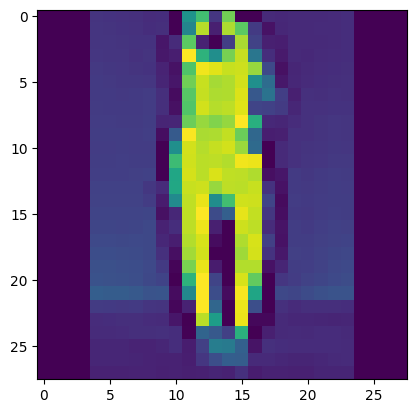

In [7]:
plt.imshow(x.squeeze())

# Model

In [8]:
class ConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(channels, 10, kernel_size=3, padding="same"),
      nn.ReLU(),
      nn.Conv2d(10, 5, kernel_size=3, padding="same"),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(width * height * 5, 64),     
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [9]:
model: nn.Module = ConvNet()

# Tensorboard 

In [10]:
%rm -rf ./logs
writer = SummaryWriter("./logs")

## Model Grapph

In [11]:
tensorboard_write_graph(writer=writer, model=model, x=X)

# Training Loop

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_idx_value = 0

In [18]:
# Define the loss function and optimizer
for epoch in range(0, 5):   # 5 epochs at maximum
    tensorboard_write_histogram(writer=writer, model=model, step=epoch)

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(loader, 0):
        if i > 1000:
            break

        # Get inputs
        inputs, targets = data

        # Write an image at every batch 0
        if i == 0:
            tensorboard_write_image(writer=writer, tag="image", image=inputs[0], step=epoch, dataformats="CWH")

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()

    # Write loss for epoch
    print('Loss at epoch %5d: %.3f' % (epoch, current_loss / 1000))
    tensorboard_write_scalar(writer=writer, tag="Loss/Epochs", value=current_loss / 1000, step=epoch)

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss at epoch     0: 0.486
Starting epoch 2
Loss at epoch     1: 0.457
Starting epoch 3
Loss at epoch     2: 0.477
Starting epoch 4
Loss at epoch     3: 0.457
Starting epoch 5
Loss at epoch     4: 0.433
Training process has finished.


# Tensorboard

In [19]:
%tensorboard --logdir ./logs/

Reusing TensorBoard on port 6006 (pid 55613), started 0:04:19 ago. (Use '!kill 55613' to kill it.)